<a href="https://colab.research.google.com/github/mposa/MEAM517/blob/master/Lecture14/van_der_pol_sos_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Drake

# New Section

## Constant V, line search over multipliers

In [ ]:
# Install drake. We are using the lqr controller in drake as the final stabilizing controller.
# The installation process will take about 2 minutes but it's only required in the start of the Colab's virtual machine.
!curl -s https://raw.githubusercontent.com/mposa/MEAM517/master/colab_drake_setup.py > colab_drake_setup.py
from colab_drake_setup import setup
setup()

<IPython.core.display.Javascript object>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199M  100  199M    0     0  9662k      0  0:00:21  0:00:21 --:--:-- 11.2M
Reading package lists...
Building dependency tree...
Reading state information...
libglu1-mesa is already the newest version (9.0.0-2.1build1).
libglu1-mesa set to manually installed.
libjsoncpp1 is already the newest version (1.7.4-3).
libjsoncpp1 set to manually installed.
liblapack3 is already the newest version (3.7.1-4ubuntu1).
liblapack3 set to manually installed.
libogg0 is already the newest version (1.3.2-1).
libogg0 set to manually installed.
libtheora0 is already the newest version (1.1.1+dfsg.1-14).
libtheora0 set to manually installed.
libxt6 is already the newest version (1:1.1.5-1).
libxt6 set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
zlib1g is already 

1.1
SolutionResult.kSolutionFound
1.3
SolutionResult.kSolutionFound
1.7000000000000002
SolutionResult.kSolutionFound
1.5000000000000002
SolutionResult.kInfeasibleConstraints
1.4000000000000001
SolutionResult.kInfeasibleConstraints
1.5000000000000002
SolutionResult.kSolutionFound
1.4500000000000002
SolutionResult.kInfeasibleConstraints
1.5000000000000002
SolutionResult.kSolutionFound
1.4750000000000003
SolutionResult.kInfeasibleConstraints
1.4625000000000004
SolutionResult.kInfeasibleConstraints
1.4562500000000003
SolutionResult.kInfeasibleConstraints
1.4625000000000004
SolutionResult.kSolutionFound
1.4593750000000003
SolutionResult.kInfeasibleConstraints
1.4578125000000004
SolutionResult.kInfeasibleConstraints
1.4593750000000003
SolutionResult.kSolutionFound
1.4585937500000004
SolutionResult.kInfeasibleConstraints
Done!
1.4578125000000004


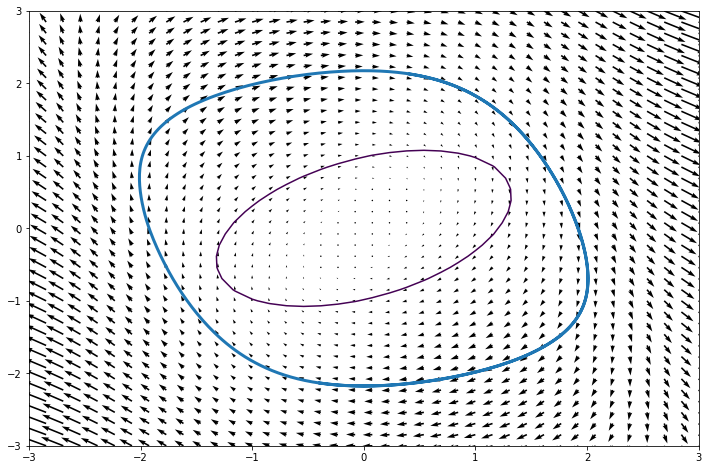

In [ ]:
import math

import numpy as np
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
import pydrake.symbolic as sym
from pydrake.symbolic import Polynomial
from scipy.linalg import solve_lyapunov
from pydrake.solvers.mathematicalprogram import SolutionResult
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Initial guess
rho = 1
delta = .1
double_next = False
rho_opt = 0

# Stopping criteria
min_delta = .001

while delta > min_delta:
  # Initialize an empty optimization program.
  prog = MathematicalProgram()

  # Declare state "x" as indeterminates
  x = prog.NewIndeterminates(2)

  # Dynamics
  a = 1
  xdot = np.array([-a*(x[0] - x[0]**3 / 3 - x[1]),  -x[0]/a])

  # Solve Lyapunov equation for V
  A = np.array([[-a, a], [-1/a, 0]])
  Q = np.identity(2);
  #Q = np.array([[10, 0], [0, 1]])
  S=solve_lyapunov(A.T, -Q)
  V = x.T @ S @ x;
  Vdot = V.Jacobian(x) @ xdot

  sig_poly = prog.NewSosPolynomial(sym.Variables(x), 4)
  sig = sig_poly[0].ToExpression()

  p1 = (V - rho) * sig - Vdot
  #p1 = (V - rho)  - Vdot

  prog.AddSosConstraint(p1);

  prog.AddCost(-rho);

  # Solve program
  result = Solve(prog)
  if result.get_solution_result() == SolutionResult.kSolutionFound:
    rho_opt = rho
    if double_next:
      delta = delta * 2
    double_next = True
    rho = rho + delta
  else:
    delta = delta/2
    rho = rho - delta
    double_next = False
  print(rho)
  print(result.get_solution_result())
  

print("Done!")
print(rho_opt)

# Plotting
def dynamics(t, x) : return [a*(x[0] - x[0]**3 / 3 - x[1]),  x[0]/a]
ode_sol = solve_ivp(dynamics, [0, 20], [0, 3], t_eval=np.linspace(0, 20, 1000))

Vsol = result.GetSolution(V)
N_sample = 40
x1_sample, x2_sample = np.meshgrid(np.linspace(-3,3,N_sample), np.linspace(-3,3,N_sample))
Vplot = np.zeros([N_sample, N_sample])
x1dot = np.zeros([N_sample, N_sample])
x2dot = np.zeros([N_sample, N_sample])
for i in range(x1_sample.shape[0]):
  for j in range(x1_sample.shape[1]):
    env = {x[0] : x1_sample[i][j], x[1]: x2_sample[i][j]}
    Vplot[i][j] = Vsol.Evaluate(env)
    x1dot[i][j] = xdot[0].Evaluate(env)
    x2dot[i][j] = xdot[1].Evaluate(env)

plt.rcParams['figure.figsize'] = [12,8];
plt.quiver(x1_sample, x2_sample, x1dot, x2dot);
plt.contour(x1_sample, x2_sample, Vplot, [rho]);
plt.plot(ode_sol.y[0,500:], ode_sol.y[1,500:], linewidth=3);

## Constant multipliers, search V

SolutionResult.kSolutionFound
(7.2690721006307095e-24 - 0.072059705579451183 * (x(0) * x(1)) + 0.0095996257435424625 * (x(0) * pow(x(1), 3)) - 0.0001270594015780856 * (x(0) * pow(x(1), 5)) - 0.096239719481736777 * (pow(x(0), 2) * pow(x(1), 2)) + 0.00541894181018957 * (pow(x(0), 2) * pow(x(1), 4)) + 3.1623655305089365e-06 * (pow(x(0), 3) * x(1)) - 3.2996022785910285e-07 * (pow(x(0), 3) * pow(x(1), 3)) + 3.4358142763869409e-12 * (pow(x(0), 4) * pow(x(1), 2)) - 8.7943441444032963e-18 * (pow(x(0), 5) * x(1)) + 0.44984675964002058 * pow(x(0), 2) + 4.7870099676197126e-12 * pow(x(0), 4) + 2.5915354988081478e-21 * pow(x(0), 6) + 0.67659125667899922 * pow(x(1), 2) - 0.11413128128886676 * pow(x(1), 4) + 0.0057159083665559648 * pow(x(1), 6))


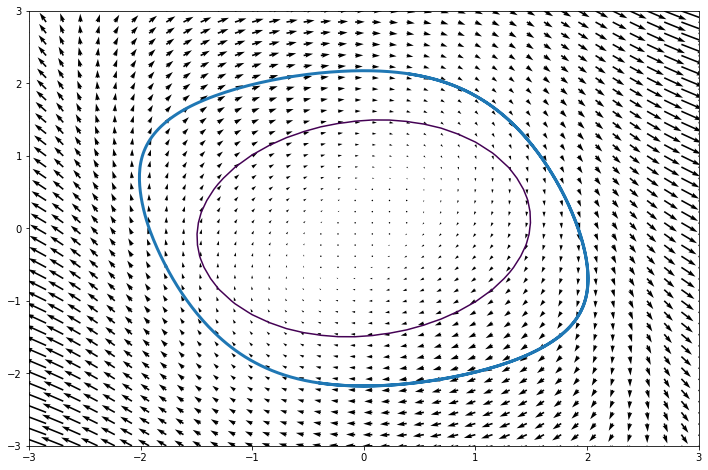

In [ ]:
import math

import numpy as np
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve, SolverOptions, SolverType, ChooseBestSolver
import pydrake.symbolic as sym
from pydrake.symbolic import Polynomial
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Initialize an empty optimization program.
prog = MathematicalProgram()

# Declare state "x" as indeterminates
x = prog.NewIndeterminates(2)

# parameters
degree = 6
sigma_degree = 8

# Dynamics
a = 1
xdot = np.array([-a*(x[0] - x[0]**3 / 3 - x[1]),  -x[0]/a])

rho = 1

V_poly = prog.NewSosPolynomial(sym.Variables(x), degree)
V = V_poly[0].ToExpression()
Vdot = V.Jacobian(x) @ xdot

# Constrain V(0,0) = 0
env_0 = {x[0] : 0, x[1]: 0}
prog.AddLinearConstraint(V.EvaluatePartial(env_0) == 0)

sigma_1 = (x.T @ x) ** (sigma_degree/2)
sigma_2 = (1 + x.T @ x) ** (sigma_degree/2 - 1)

p1 = sigma_1 * (V - rho) - sigma_2 * Vdot

prog.AddSosConstraint(p1);

# Create a cost by sampling over points
N_sample = 5
x1_sample, x2_sample = np.meshgrid(np.linspace(-3,3,N_sample), np.linspace(-3,3,N_sample))
for i in range(x1_sample.shape[0]):
  for j in range(x1_sample.shape[1]):
    env = {x[0] : x1_sample[i][j], x[1]: x2_sample[i][j]}
    prog.AddCost(V.EvaluatePartial(env))

# Solve program
result = Solve(prog)
print(result.get_solution_result())

# Print resulting V
print(result.GetSolution(V))

# Plotting
def dynamics(t, x) : return [a*(x[0] - x[0]**3 / 3 - x[1]),  x[0]/a]
ode_sol = solve_ivp(dynamics, [0, 20], [0, 3], t_eval=np.linspace(0, 20, 1000))

Vsol = result.GetSolution(V)
N_sample = 40
x1_sample, x2_sample = np.meshgrid(np.linspace(-3,3,N_sample), np.linspace(-3,3,N_sample))
Vplot = np.zeros([N_sample, N_sample])
x1dot = np.zeros([N_sample, N_sample])
x2dot = np.zeros([N_sample, N_sample])
for i in range(x1_sample.shape[0]):
  for j in range(x1_sample.shape[1]):
    env = {x[0] : x1_sample[i][j], x[1]: x2_sample[i][j]}
    Vplot[i][j] = Vsol.Evaluate(env)
    x1dot[i][j] = xdot[0].Evaluate(env)
    x2dot[i][j] = xdot[1].Evaluate(env)

plt.rcParams['figure.figsize'] = [12,8];
plt.quiver(x1_sample, x2_sample, x1dot, x2dot);
plt.contour(x1_sample, x2_sample, Vplot, [1]);
plt.plot(ode_sol.y[0,500:], ode_sol.y[1,500:], linewidth=3);